 # Titanic - Predict Survivors    
 
 A decision tree classifier is used to predict the persons that will survive the titanic incident.  
 The missing age values is replaced with the mean age of the designation group the person belonged to.
 
From the data it is observed that females were more likely to survive.  Within the females group married females were more likely to survive.  
 Persons from Pclass 1 were more likely to survive than persons from pclass2 and pclass3.

In [252]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


## 1. Read file in

In [253]:
df = pd.read_csv("../input/titanic/train.csv")
df2 = pd.read_csv("../input/titanic/test.csv")

In [254]:
df.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
68,69,1,3,"Andersson, Miss. Erna Alexandra",female,17.0,4,2,3101281,7.925,NaN,S
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.000,NaN,S
699,700,0,3,"Humblen, Mr. Adolf Mathias Nicolai Olsen",male,42.0,0,0,348121,7.650,F G63,S
757,758,0,2,"Bailey, Mr. Percy Andrew",male,18.0,0,0,29108,11.500,NaN,S
241,242,1,3,"Murphy, Miss. Katherine ""Kate""",female,NaN,1,0,367230,15.500,NaN,Q


In [255]:
Id = df2.iloc[:,0]
Id

0       892
1       893
2       894
3       895
4       896
       ... 
413    1305
414    1306
415    1307
416    1308
417    1309
Name: PassengerId, Length: 418, dtype: int64

##  2.  Check the quality of the data

In [256]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [257]:
print(df.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


## 3.  Replace missing values and drop unnecessary columns

In [258]:
df.drop(['Cabin', 'PassengerId', 'Ticket', 'Fare'], axis = 1, inplace = True)
df2.drop(['Cabin', 'PassengerId', 'Ticket', 'Fare'], axis = 1, inplace = True)
df.sample(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Embarked
465,0,3,"Goncalves, Mr. Manuel Estanslas",male,38.0,0,0,S
415,0,3,"Meek, Mrs. Thomas (Annie Louise Rowley)",female,NaN,0,0,S
175,0,3,"Klasen, Mr. Klas Albin",male,18.0,1,1,S
121,0,3,"Moore, Mr. Leonard Charles",male,NaN,0,0,S
834,0,3,"Allum, Mr. Owen George",male,18.0,0,0,S


### Embarked  
Replace missing Embarked values with embarked value with highest frequency

In [259]:
from collections import Counter
result = Counter(df['Embarked'].tolist())
result

Counter({'S': 644, 'C': 168, 'Q': 77, nan: 2})

In [260]:
df.Embarked.fillna('S', inplace=True)
df2.Embarked.fillna('S', inplace=True)

### Age  
Replace missing age values with average age for designation

In [261]:
df['Name'] = df['Name'].str.split(', ').str[1]
df['Name'] = df['Name'].str.split('.').str[0]
df.rename(columns = {'Name':'Designation'}, inplace = True)

df2['Name'] = df2['Name'].str.split(', ').str[1]
df2['Name'] = df2['Name'].str.split('.').str[0]
df2.rename(columns = {'Name':'Designation'}, inplace = True)

Reduce number of designations 

In [262]:
df.Designation.value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: Designation, dtype: int64

In [263]:
df['Designation'] = df['Designation'].replace({'Capt':'Mr','Col':'Mr','Major':'Mr','Rev':'Mr','Mme':'Miss','Mlle':'Miss', 'Ms':'Miss', 'the Countess':'Miss', 'Lady':'Mrs', 'Don':'Mr', 'Jonkheer':'Mr', 'Sir':'Mr'})

In [264]:
df2.Designation.value_counts()

Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Ms          1
Dr          1
Dona        1
Name: Designation, dtype: int64

In [265]:
df2['Designation']=df2['Designation'].replace({'Rev':'Mr','Ms':'Miss','Col':'Mr', 'Dona':'Miss'})

In [266]:
df['Age'] = df.groupby(['Pclass','Designation', 'Parch']).Age.transform(lambda x: x.fillna(x.mean()))
df.Age = df.Age.round(2)
df.sample(5)

,Survived,Pclass,Designation,Sex,Age,SibSp,Parch,Embarked
68,1,3,Miss,female,17.0,4,2,S
499,0,3,Mr,male,24.0,0,0,S
708,1,1,Miss,female,22.0,0,0,S
343,0,2,Mr,male,25.0,0,0,S
718,0,3,Mr,male,28.9,0,0,Q


In [267]:
df2['Age'] = df.groupby(['Pclass','Designation', 'Parch']).Age.transform(lambda x: x.fillna(x.mean()))
df2.Age = df2.Age.round(2)
df2.sample(5)

,Pclass,Designation,Sex,Age,SibSp,Parch,Embarked
226,3,Mr,male,19.0,0,0,S
205,1,Mr,male,2.0,0,0,C
376,3,Miss,female,22.0,2,0,S
73,1,Mr,male,26.0,0,0,C
98,3,Miss,female,34.0,0,0,S


In [268]:
df.describe(include='all')

,Survived,Pclass,Designation,Sex,Age,SibSp,Parch,Embarked
count,891.000000,891.000000,891,891,891.000000,891.000000,891.000000,891
unique,NaN,NaN,5,2,NaN,NaN,NaN,3
top,NaN,NaN,Mr,male,NaN,NaN,NaN,S
freq,NaN,NaN,531,577,NaN,NaN,NaN,646
mean,0.383838,2.308642,NaN,NaN,29.522503,0.523008,0.381594,NaN
std,0.486592,0.836071,NaN,NaN,13.569795,1.102743,0.806057,NaN
min,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN
25%,0.000000,2.000000,NaN,NaN,21.700000,0.000000,0.000000,NaN
50%,0.000000,3.000000,NaN,NaN,28.900000,0.000000,0.000000,NaN
75%,1.000000,3.000000,NaN,NaN,36.750000,1.000000,0.000000,NaN


##  4.  Investigate the survival rate among different groups

In [269]:
dfs = [rows for _, rows in df.groupby('Survived')]

SurS= pd.DataFrame()
SurS["Sur_Sex"] = dfs[1]["Sex"].value_counts().to_frame()
SurS["Not_Sur_Sex"] = dfs[0]["Sex"].value_counts().to_frame()
SurS["Total"]=SurS["Sur_Sex"]+SurS["Not_Sur_Sex"]
SurS["%"]=(SurS["Sur_Sex"]/SurS["Total"])*100
SurS

,Sur_Sex,Not_Sur_Sex,Total,%
female,233,81,314,74.203822
male,109,468,577,18.890815


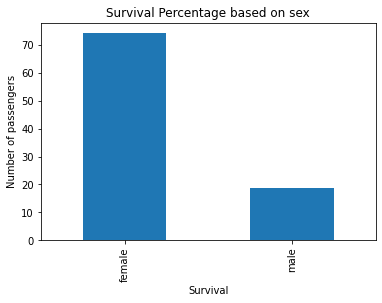

In [270]:
SurS["%"].transpose().plot(kind = 'bar')
plt.ylabel('Number of passengers')
plt.xlabel('Survival')
plt.title('Survival Percentage based on sex')

plt.show()

#  Females were more likely to survive than males

In [271]:
SurPc= pd.DataFrame()
SurPc["Sur_Pclass"] = dfs[1]["Pclass"].value_counts().to_frame()
SurPc["Not_Sur_Pclass"] = dfs[0]["Pclass"].value_counts().to_frame()
SurPc["Total"]=SurPc["Sur_Pclass"]+SurPc["Not_Sur_Pclass"]
SurPc["%"]=(SurPc["Sur_Pclass"]/SurPc["Total"])*100
SurPc

,Sur_Pclass,Not_Sur_Pclass,Total,%
1,136,80,216,62.962963
3,119,372,491,24.236253
2,87,97,184,47.282609


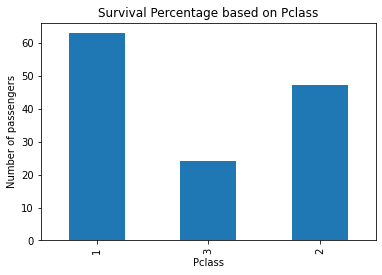

In [272]:
SurPc["%"].transpose().plot(kind = 'bar')

plt.ylabel('Number of passengers')
plt.xlabel('Pclass')
plt.title('Survival Percentage based on Pclass')

plt.show()

#  Persons from Pclass 1 were more likely to survive

In [273]:
SurDes= pd.DataFrame()
SurDes["Sur_Designation"] = dfs[1]["Designation"].value_counts().to_frame()
SurDes["Not_Sur_Designation"] = dfs[0]["Designation"].value_counts().to_frame()
SurDes["Total"]=SurDes["Sur_Designation"]+SurDes["Not_Sur_Designation"]
SurDes["%"]=(SurDes["Sur_Designation"]/SurDes["Total"])*100
SurDes

,Sur_Designation,Not_Sur_Designation,Total,%
Miss,132,55,187,70.588235
Mrs,100,26,126,79.365079
Mr,84,447,531,15.819209
Master,23,17,40,57.500000
Dr,3,4,7,42.857143


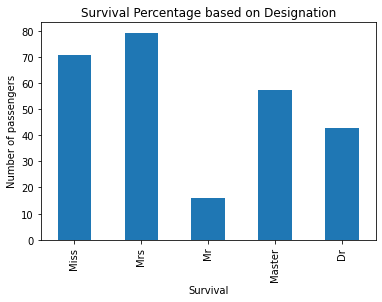

In [274]:
SurDes["%"].transpose().plot(kind = 'bar')

plt.ylabel('Number of passengers')
plt.xlabel('Survival')
plt.title('Survival Percentage based on Designation')

plt.show()

# Married females were more likely to survive than non married females.  
# Males with the title master were more likely to survive than males with the title Mr.

In [275]:
SurSS= pd.DataFrame()
SurSS["Sur_SibSp"] = dfs[1]["SibSp"].value_counts().to_frame()
SurSS["Not_Sur_SibSp"] = dfs[0]["SibSp"].value_counts().to_frame()
SurSS["Total"]=SurSS["Sur_SibSp"]+SurSS["Not_Sur_SibSp"]
SurSS["%"]=(SurSS["Sur_SibSp"]/SurSS["Total"])*100
SurSS

,Sur_SibSp,Not_Sur_SibSp,Total,%
0,210,398,608,34.539474
1,112,97,209,53.588517
2,13,15,28,46.428571
3,4,12,16,25.000000
4,3,15,18,16.666667


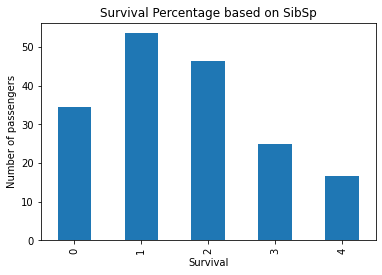

In [276]:
SurSS["%"].transpose().plot(kind = 'bar')

plt.ylabel('Number of passengers')
plt.xlabel('Survival')
plt.title('Survival Percentage based on SibSp')

plt.show()

# Persons with one sibling or spouse on board were more likely to survive

In [277]:
SurPar= pd.DataFrame()
SurPar["Sur_Parch"] = dfs[1]["Parch"].value_counts().to_frame()
SurPar["Not_Sur_Parch"] = dfs[0]["Parch"].value_counts().to_frame()
SurPar["Total"]=SurPar["Sur_Parch"]+SurPar["Not_Sur_Parch"]
SurPar["%"]=(SurPar["Sur_Parch"]/SurPar["Total"])*100
SurPar

,Sur_Parch,Not_Sur_Parch,Total,%
0,233,445,678,34.365782
1,65,53,118,55.084746
2,40,40,80,50.000000
3,3,2,5,60.000000
5,1,4,5,20.000000


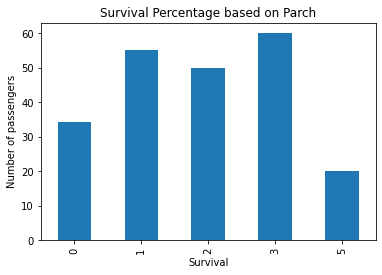

In [278]:
SurPar["%"].transpose().plot(kind = 'bar')

plt.ylabel('Number of passengers')
plt.xlabel('Survival')
plt.title('Survival Percentage based on Parch')

plt.show()

# Persons with 3 Parents and/or children on board were more likely to survive

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Age'>

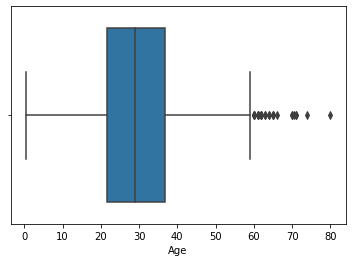

In [279]:
sns.boxplot('Age', data=df)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Age'>

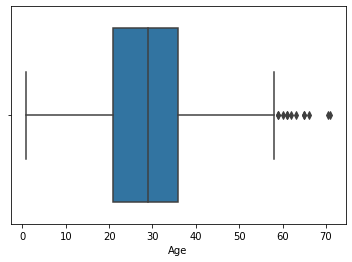

In [280]:
sns.boxplot('Age', data=df2)

## 5.  Build Decision tree classifier

In [281]:
#One hot encoding (sex)
df = pd.get_dummies(df, columns = ['Sex', 'Embarked', 'Designation'])
df.sample(5)

,Survived,Pclass,Age,SibSp,Parch,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Designation_Dr,Designation_Master,Designation_Miss,Designation_Mr,Designation_Mrs
876,0,3,20.0,0,0,0,1,0,0,1,0,0,0,1,0
549,1,2,8.0,1,1,0,1,0,0,1,0,1,0,0,0
67,0,3,19.0,0,0,0,1,0,0,1,0,0,0,1,0
453,1,1,49.0,1,0,0,1,1,0,0,0,0,0,1,0
221,0,2,27.0,0,0,0,1,0,0,1,0,0,0,1,0


<AxesSubplot:>

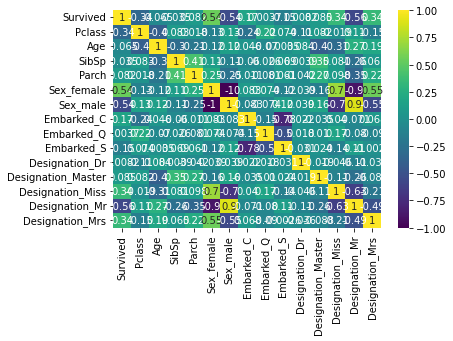

In [282]:
sns.heatmap(df.corr(), annot = True, cmap="viridis")

# From the heat map it is observed that sex had the higest impac on whether a person would have survived

In [283]:
#One hot encoding (sex)
df2 = pd.get_dummies(df2, columns = ['Sex', 'Embarked', 'Designation'])
df2.sample(5)

,Pclass,Age,SibSp,Parch,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Designation_Dr,Designation_Master,Designation_Miss,Designation_Mr,Designation_Mrs
352,2,15.0,0,0,0,1,0,0,1,0,0,0,1,0
134,3,25.0,0,0,0,1,0,0,1,0,0,0,1,0
356,1,22.0,2,0,1,0,0,0,1,0,0,0,0,1
400,1,39.0,0,0,1,0,0,0,1,0,0,1,0,0
135,3,23.0,0,0,0,1,0,0,1,0,0,0,1,0


In [284]:
# Split data into X and Y groups
X = df.iloc[:, 1:15]
y = df.iloc[:,0]

In [285]:
# Split the data into the train set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
print(X_train.shape,X_test.shape)

(668, 14) (223, 14)


Accuracy score of the optimal tree = 82.06%
Tree depth = 4 
Number of leaves = 16


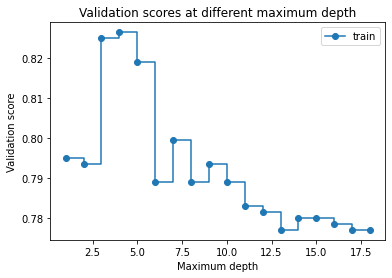

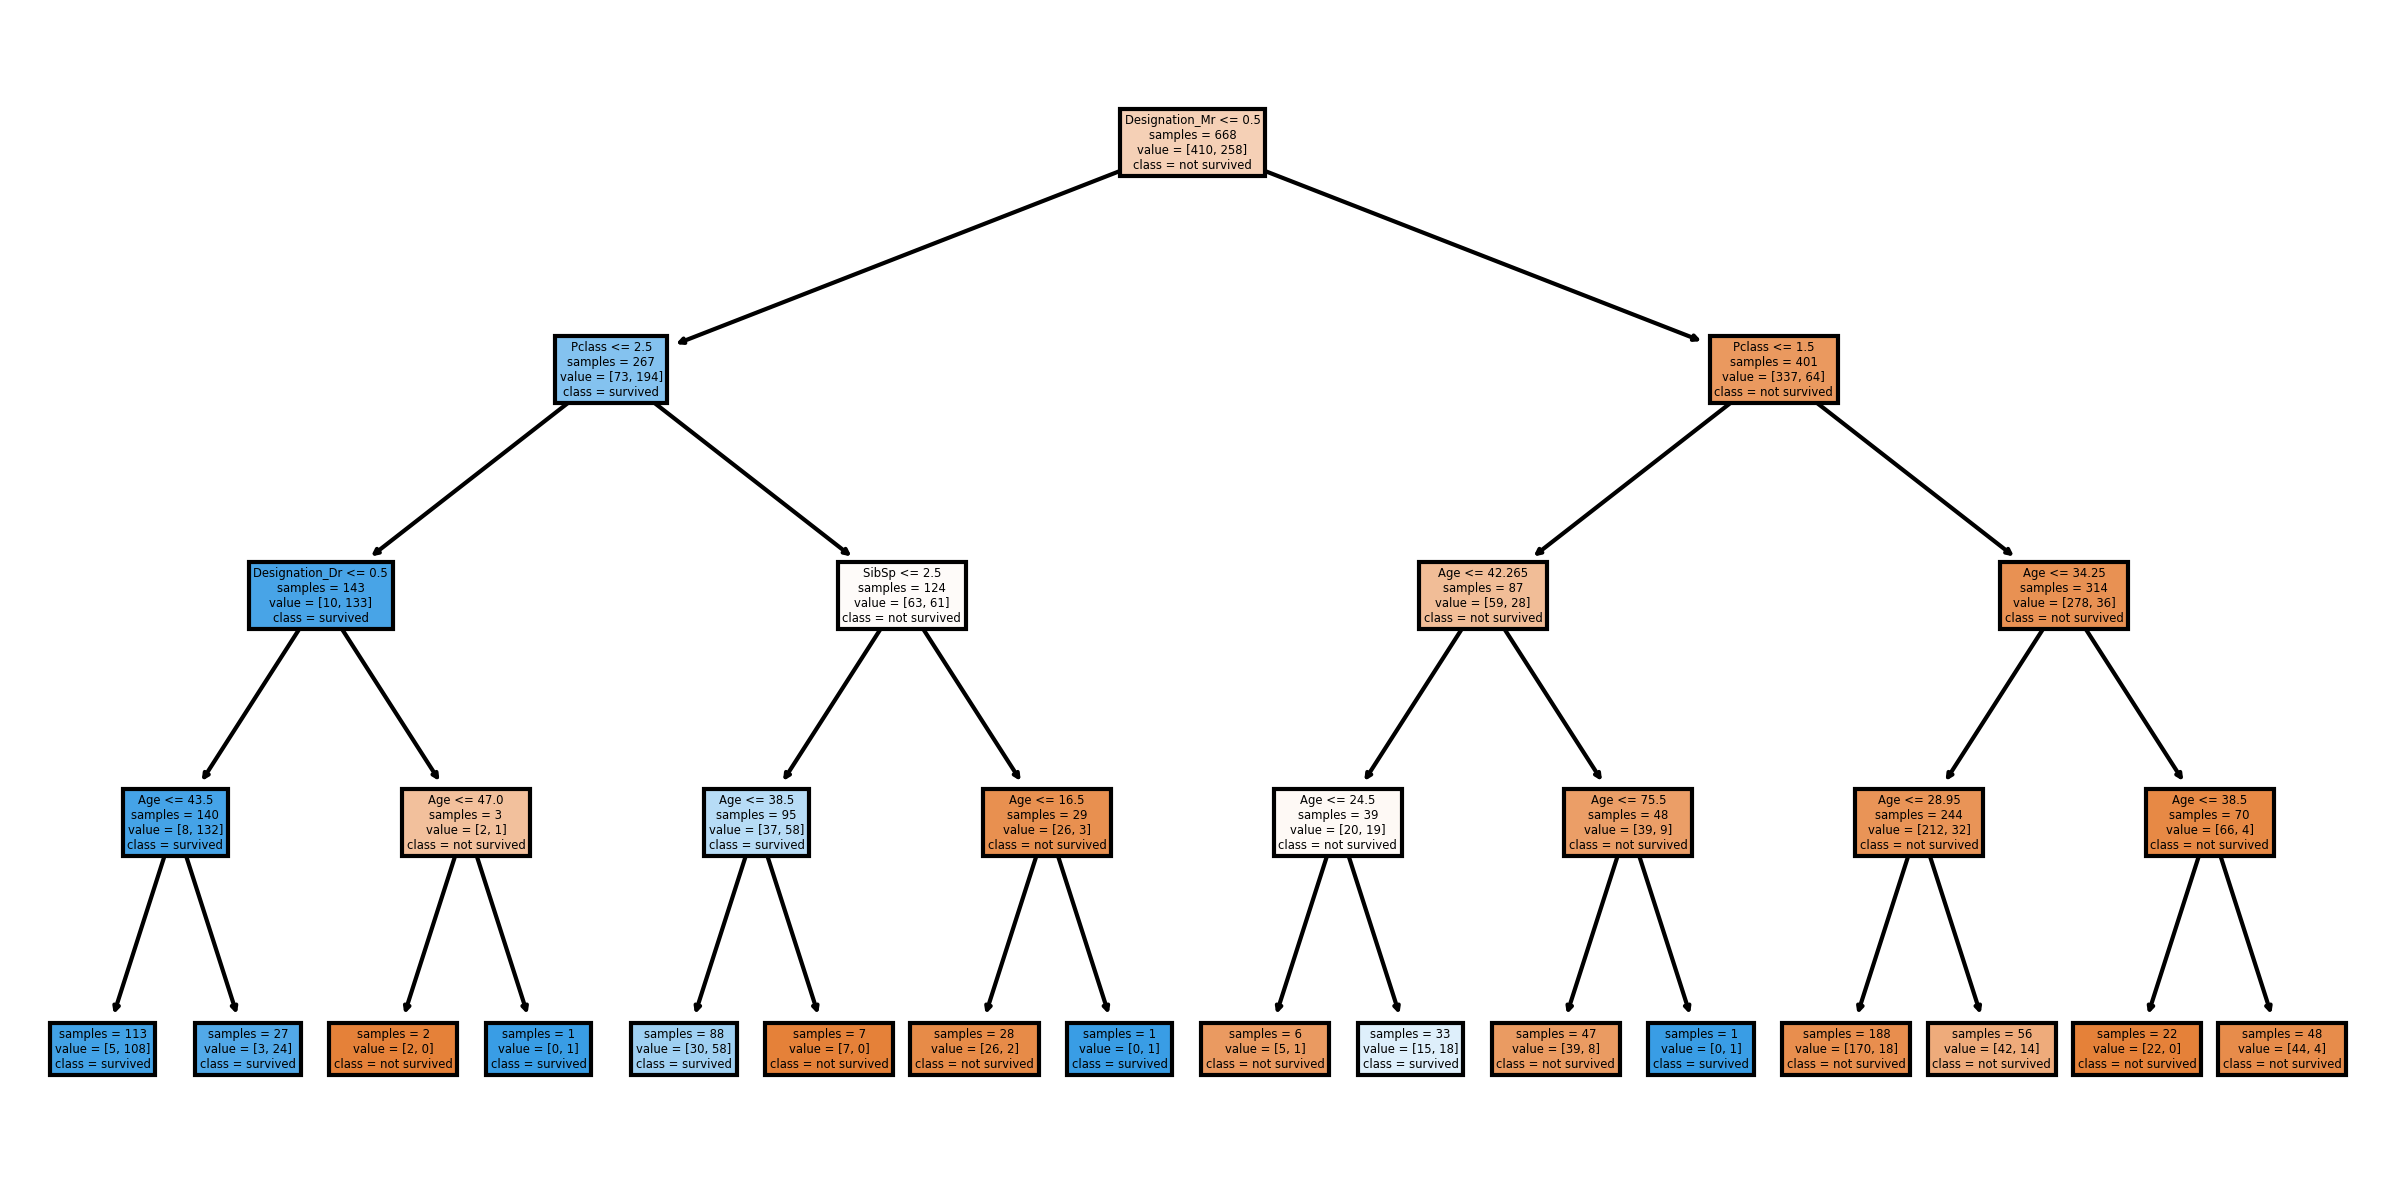

In [286]:
#Fit model to be used in future
samples = [sample for sample in range(1,19)]  
# In order to find the optimal maximum depth, cross validation is applied
validation_scores = []
for sample in samples:
    classifier = DecisionTreeClassifier(criterion = 'gini', random_state=1, max_depth=sample)
    score = cross_val_score(estimator=classifier, X=X_train, y=y_train, cv=5)   
    validation_scores.append(score.mean())

# Visualise the validation score in relation to maximum depth
plt.figure()
plt.xlabel("Maximum depth")
plt.ylabel("Validation score")
plt.title("Validation scores at different maximum depth")
plt.plot(samples, validation_scores, marker='o', label="train",
        drawstyle="steps-post")
plt.legend()

# Obtain the maximum depth with the highest validation score
depth_optimum = samples[validation_scores.index(max(validation_scores))]

# Use the optimum maximum depth to fit tree
classifier = DecisionTreeClassifier(criterion = 'gini', random_state=0, max_depth=depth_optimum)
classifier.fit(X_train, y_train)

# Final test to see how the model performs:
y_pred = classifier.predict(X_test)
test_score2 = accuracy_score(y_test, y_pred)
print("Accuracy score of the optimal tree = {:2.2%}".format(test_score2))
print("Tree depth =",classifier.get_depth(),'\n'
      "Number of leaves =",classifier.get_n_leaves()) 
plt.show()

# Show the first few levels of the tree
plt.figure(figsize=[10,5], dpi=300)
plot_tree(classifier, max_depth=depth_optimum,
         feature_names=X_train.columns, 
          class_names=['not survived', 'survived'],
          impurity=False,
          filled=True)
plt.show()


In [287]:
# Export results
y_pred2=classifier.predict(df2)
results_df = pd.DataFrame()
results_df['PassengerId'] = Id
results_df['Survived'] = y_pred2
results_df.to_csv('Results.csv", index= False')
results_df

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
